## ALUMNO: JOSE  DE JESUS HERRERA LEDON
## PERCEPCION COMPUTACIONAL
## GRUPO 9


### Anomalia: Sal y pimienta (generado)
#### Se utilzaran dos imagenes a color a las que se les generara artificailmente una anomalia aleatoria de puntos negros y blancos, despues se utilizata una tecnica de HIstograma para recuperar en medida de lo posigle la imagen original. 

####  Este proyecot incluye un archivo requiremets.txt  y un README relacionados con las dependencias y la ejecucion del documento

In [1]:
# python librearies
from random import randrange, choice
# External libraries
from PIL import Image
from matplotlib import image
from matplotlib import pyplot
from numpy import asarray, array, copy, mean, isnan, linalg

RGB


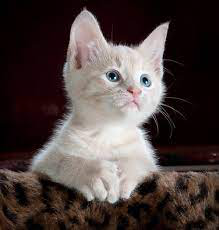

In [2]:
image_easy_colors = Image.open('gato_blanco.jpeg', mode='r', formats=['jpeg'])
image_easy_array = asarray(image_easy_colors)
image_grey_cat =  Image.open('gato_gris.jpeg')
image_grey_cat_array = asarray(image_grey_cat)
print(image_easy_colors.mode)
image_easy_colors

RGB


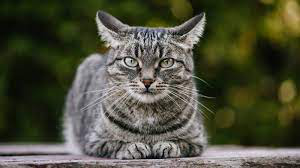

In [3]:
print(image_grey_cat.mode)
image_grey_cat

### Antes de agregar el ruidoa  a la imagen es necesario mapear la imagen en un vector representativo a la imagen


#### Las imagenes estan seleccionadas en formato jpeg RGB, el trabajo con png y la libreria de Pillow para retornar las imagenes no funciono correctamente

#### El formato RGB mapea cada pizel en un grupo de 3 valores, Rojo, Verde y Azu de 0 a 255 en cada uno de ellos.

#### Un pixel negro se representa como [0, 0, 0] y un pixel blanco con [255, 255, 255], conforme al modelo RGB (sistema de color aditivo)

### Veamos que pasa si cambiamos la mitad de la imagen a pixeles negros


## Creando la anomalia sal y pimienta

In [4]:
def random_tuple(range_top_x, range_top_y):
    _x = randrange(range_top_x)
    _y = randrange(range_top_y)
    return (_x, _y)

def add_sald_and_pepper(image_array, percentage_of_anomaly:int =10):
    black_pixel = array([0,0,0])
    white_pixel = array([255, 255, 255])
    salt_and_paper_arr = [black_pixel, white_pixel]
    cols = len(image_array)
    rows = len(image_array[0])
    num_anomalous_pixels = int((cols * rows) * (percentage_of_anomaly/100))
    possition_of_anomalies = [random_tuple(cols, rows) for i in range(num_anomalous_pixels)]
    _image_array = copy(image_array)
    for position in possition_of_anomalies:
        _image_array[position[0], position[1]] = choice(salt_and_paper_arr)
    return _image_array
anomalous_image = add_sald_and_pepper(image_grey_cat_array)

(168, 300, 3)


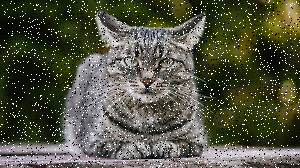

In [5]:
_ = Image.fromarray(anomalous_image)
print(anomalous_image.shape)
_

### Ahora se extraen todos los vecinos de cada pixel

In [6]:
def pos_eval(possition, border_row, border_col):
    is_valid = True
    if possition[0] < 0 or possition[1] < 0:
        is_valid = False
        return is_valid
    if possition[0] >= border_row or possition[1] >= border_col:
        is_valid = False
    return is_valid

def mean_from_points(points:list, index:int):
    values  = [value[index] for value in points]
    return mean(values)

#fix by average of pixels arroud  right, left, top, button, right-top, right-buton, left-right, left-button
def pixel_points_for_mean(image_array, row, col, border_row, border_col):
    pixel = image_array[row, col]
    pixels_to_average = []
    # Movements
    row_down = row -1
    row_up = row + 1
    col_left = col - 1
    col_right = col + 1
    # possitions to evaluate
    right_pos = (row, col_right)
    left_pos = (row, col_left)
    top_pos = (row_up, col)
    button_pos = (row_down, col)
    right_top_pos = (row_up, col_right)
    right_button_pos = (row_down, col_right)
    left_top_pos = (row_up, col_left)
    left_button_pos = (row_down, col_left)
    possitions = [
        right_pos,
        left_pos,
        top_pos,
        button_pos,
        right_top_pos,
        right_button_pos,
        left_top_pos,
        left_button_pos
    ]
    valid_possitions = []
    for possition in possitions:
        if pos_eval(possition, border_row, border_col):
            valid_possitions.append(possition)
    return valid_possitions
    

In [7]:
def image_neighbours(image_array):
    neighbords = {}
    border_row = len(image_array)-1
    border_col = len(image_array[0])-1
    print(f"border_row: {border_row}")
    print(f"border_col: {border_col}")
    for row in range(border_row):
        for col in range(border_col):
            neighbords.update({(row,col): pixel_points_for_mean(image_array, row, col, border_row, border_col)})
    return neighbords
neighbords = image_neighbours(anomalous_image)
# neighbords
print(neighbords[(166, 298)])

border_row: 167
border_col: 299
[(166, 297), (165, 298), (165, 297)]


### Ahora que los vecinos estan definidos para cada pixel se va a evaluar el el mean de cada valor de r, g y b en cada posicion

In [8]:
def get_pixels_by_neighbords(neighbords, anomalous_image):
    neighbords_pixels_dict = {}
    for possition in neighbords.keys():
        list_of_neighbords = neighbords[possition]
        neighbords_pixels = []
        for neighbord_possition in list_of_neighbords:
            
            try:
                pixel=anomalous_image[neighbord_possition[0], neighbord_possition[1]]
                neighbords_pixels.append(pixel)
            except:
                pass
        neighbords_pixels_dict.update({possition: neighbords_pixels})
    return neighbords_pixels_dict


def get_mean_for_neighbords(pixels_by_neighbords:dict, anomalous_image):
    average_values = {}
    rgb_mean = {
        'r': 0,
        'g': 0,
        'b': 0
    }
    for possition in pixels_by_neighbords.keys():
        pixel_neighbords = neighbords[possition]
        if pixel_neighbords:
            this_rgb_mean = rgb_mean.copy()
            this_rgb_mean['r'] = mean_from_points(pixels_by_neighbords[possition], 0)
            this_rgb_mean['g'] = mean_from_points(pixels_by_neighbords[possition], 1)
            this_rgb_mean['b'] = mean_from_points(pixels_by_neighbords[possition], 2)
            average_values.update({possition: this_rgb_mean})
    return average_values


In [9]:
pixels_by_neighbords = get_pixels_by_neighbords(neighbords, anomalous_image)
print(pixels_by_neighbords[(165, 297)])

[array([30, 25, 19], dtype=uint8), array([20, 15,  9], dtype=uint8), array([41, 36, 30], dtype=uint8), array([59, 54, 48], dtype=uint8), array([52, 47, 41], dtype=uint8), array([255, 255, 255], dtype=uint8), array([24, 19, 13], dtype=uint8), array([59, 54, 48], dtype=uint8)]


In [10]:
pixel_neighbords_mean = get_mean_for_neighbords(pixels_by_neighbords, anomalous_image)

In [11]:
print(pixel_neighbords_mean[(165, 297)])
# pixel_neighbords_mean

{'r': 67.5, 'g': 63.125, 'b': 57.875}


## Ahora tenemos el mean de cada pixel basado en sus vecinos, pero no todos los pixeles necesitan cambiar necesariamente, solo si el color actual y el del mean son demaciado diferentes, para eso habra que encontrarlos, una aproximacion podria ser calcular la distancia vectorial entre los colores, es tal vez muy costoso computacionalmente. 

### El criterio de distancia se puede modificar


In [12]:
def pixel_distance_replacer(anomalous_image, pixel_neighbords_mean, distance_max=100):
    fixed_image = copy(anomalous_image)
    for pixel_poss in pixel_neighbords_mean.keys():
        try:
            current_pixel = anomalous_image[pixel_poss[0], pixel_poss[1]]
            neighbords_pixel_sugested = array(
                [
                    pixel_neighbords_mean[pixel_poss]['r'],
                    pixel_neighbords_mean[pixel_poss]['g'],
                    pixel_neighbords_mean[pixel_poss]['b']
                ]
            )

            distance = linalg.norm(current_pixel- neighbords_pixel_sugested)
            if distance > distance_max:
                fixed_image[pixel_poss[0], pixel_poss[1]] = neighbords_pixel_sugested
        except:
            pass
    return fixed_image

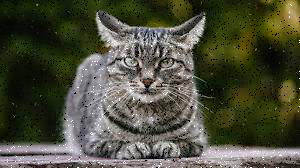

In [14]:
fixed_image = pixel_distance_replacer(anomalous_image, pixel_neighbords_mean, 200)
_ = Image.fromarray(fixed_image)
_.save('gato_gris_fixed.jpeg')
_